# Saisonales Pflanzenwachstum <br> (Sentinel-2 L3 WASP - Monatliche Komposite)

**Autor*in:** Julian Hausmann
**Copyright:** © 2025 Urbetho CF GmbH
**Lizenz:** Dieses Notebook steht unter der [CC BY-NC-SA 4.0 License](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en).

<div style="text-align: right"><i> Fortgeschritten </i></div>

In diesem Notebook stellen wir über einen Keycloak-Token und mithilfe der requests Bibliothek und dem OData-Protokoll Zugang zum EO-LAB Datenarchiv her. Wir verwenden das [Sentinel-2 L3 WASP](https://code-de.org/de/portfolio/?id=e7169de6-bab6-4dac-b094-9c9c546d28ee) Produkt, das für jeden Monat eine nahezu wolkenfreie Zusammenstellung atmosphärisch korrigierter Sentinel-2 Daten (Sentinel-2 L2A MAJA) über Deutschland liefert. Basierend auf diesen Daten wird eine einjährige Zeitreihe von NDVI Werten für ein Naturschutzgebiet errechnet. Diese Daten können dann verwendet werden, um zum Beispiel den Beginn oder das Ende der Wachstumssaison oder die maximale Vegetationsdichte zu berechnen.  

Die Geometrie des für die Analyse verwendeten Naturschutzgebiets wird über einen Web Feature Service (WFS) des Bundesamt für Naturschutz (BfN) geladen. Der oder die Nutzer*in kann dabei über eine Eingabe selbst festlegen, welches Naturschutzgebiet untersucht werden soll. Die Eingabe wird außerdem genutzt, um über die `nominatim` Bibliothek die passenden Koordinaten des Naturschutzgebietes zu finden, um über die EO-LAB API die passenden Sentinel-2 L3 WASP Daten zu finden. Die Verzahnung des BfN WFS und dem Katalog von EO-LAB zeigt hier beispielhaft, wie die Automatisierung von Prozessen über die Cloud-Infrastruktur ablaufen kann.

**General Note 1**: Ausführung der Zellen durch pressen des <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button vom top MENU (oder `Shift` + `Enter`).

**General Note 2**: Falls der Kern nich mehr arbeitet, im the top MENU, klicke <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Dann, im top MENU, clicke  "Run" aund wähle "Run All Above Selected Cell".

**General Note 3**: Schauen Sie sich im [**FORUM**](https://forum.code-de.org/de/) um oder Kontaktieren Sie den Support! 
<br>

<img src="https://forwarn.forestthreats.org/sites/default/files/ndvi1.png">

*Die Abbildung zeigt beispielhaft wie Saisonales Pflanzenwachstum mit dem NDVI zusammenhängt. In einem sommergrünen Laub- und Mischwald der gemäßigten Breiten bilden wechselgrüne Bäume neue Blätter im Frühling und Sommer aus und werden sie im Herbst ab. NDVI-Werte, die die Produktivität der Vegetation angeben, sind dementsprechend in Herbst und Winter niedrig, im Frühling und Sommer hoch. Die Abbildung gehört ForWarnII und kann [hier](https://forwarn.forestthreats.org/overview/detecting-change) abgerufen werden.*

#### 1. Installieren der benötigten Bibliotheken

Verschiedene Pakete müssen installiert werden, bevor Download und Analyse der Daten gestartet werden können. Die Liste der zu installierenden Bibliotheken ist abhängig von den bereits lokal installierten Bibliotheken und muss dementsprechend erweitert werden, falls Bedarf besteht.

In [ ]:
!pip install numpy rasterio matplotlib scikit-image geopandas pyproj shapely rasterstats tqdm

#### 2. Importieren der benötigten Bibliotheken

In [22]:
# Versuche die benötigten Pakete zu installieren
try:
    # Liste aller benötigter Pakete
    import requests
    import json
    import time
    from IPython.display import clear_output
    import zipfile
    import os
    import matplotlib.pyplot as plt
    import rasterio
    from rasterio.windows import from_bounds
    from pyproj import CRS, Transformer
    import numpy as np
    from rasterio.windows import Window
    import re
    import pandas as pd
    import matplotlib.dates as mdates
    import geopandas as gpd
    from rasterstats import zonal_stats
    from tqdm import tqdm
    from geopy.geocoders import Nominatim
    import glob
    from owslib.wfs import WebFeatureService
    import geopandas as gpd
    import requests
    from io import BytesIO
    import folium
    import getpass
    import xml.etree.ElementTree as ET

    # Text Ausgabe
    print("Erfolgreiche Installation aller benötigter Pakete.")

except:

    # Text Ausgabe
    print("Nicht erfolgreiche Installation aller benötigter Pakete")

Erfolgreiche Installation aller benötigter Pakete.


#### 3. Erstellen des Keycloak-Token

Für das Herunterladen von EO-LAB Datensätzen benötigen Sie ein Autorisierungs-Token (Keycloak-Token), da nur autorisierte Benutzer Erdbeobachtungsdatenprodukte herunterladen dürfen. Sie werden ein autorisierter Benutzer, wenn sie sich auf https://eo-lab.org anmelden. In diesem Abschnitt generieren wir diesen Token und weisen ihn der Variable access_token zu, die dann im folgenden Skript mehrfach verwendet wird. Bitte geben Sie ihren eigenen Benutzernamen und das korrespondierende Passwort ein.

Mehr Informationen zum Erstellen des Keycloak-Token erhalten Sie in der EO-LAB [**Knowledge Base**](https://knowledgebase.eo-lab.org/de/latest/eodata/Using-curl-and-wget-to-download-EODATA-products-from-EO-Lab.html).

In [94]:
# Authentifizierungsparameter
client_id = "catalog-public"
grant_type = "password"
url = "https://auth.fra1-1.cloudferro.com/auth/realms/eo-lab/protocol/openid-connect/token"

# Benutzer zur Eingabe der Anmeldedaten auffordern
username = input('Benutzername: ')
password = getpass.getpass('Passowort: ')

# Anforderungsheader (benötigt für das Absenden von Formulardaten)
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
}

# Nutzdaten für die Authentifizierungsanforderung
data = {
    "grant_type": grant_type,
    "username": username,
    "password": password,
    "client_id": client_id
}

try:
    # Sende die POST-Anforderung an den Authentifizierungs-Endpunkt
    response = requests.post(url, data=data)

    # Überprüfen, ob die Authentifizierungsanforderung erfolgreich war
    if response.status_code == 200:

        # JSON-Antwort parsen, um das Zugriffstoken zu extrahieren
        token_data = response.json()
        access_token = token_data.get("access_token")

        # Erfolgsnachricht, wenn das Token empfangen wurde
        if access_token:
            print("Zugriffstoken empfangen.")

        # Fehlermeldung, wenn das Token nicht empfangen wurde
        else:
            print("Zugriffstoken nicht in der Antwort gefunden.")

    # Fehlermeldung für eine nicht erfolgreiche Anfrage
    else:
        print(f"Fehler beim Abrufen des Tokens. Status-Code: {response.status_code}")
        print(response.text)

# Fehlerbehandlung für alle Ausnahmen, die während der Anfrage auftreten
except Exception as e:
    print(f"Es ist ein Fehler aufgetreten: {e}")

Benutzername: julian.hausmann@uni-bonn.de
Passowort: ········
Zugriffstoken empfangen.


#### 4. Laden des WFS-Datensatz

Wir laden einen Datensatz ein, der Informationen zu allen deutschen Schutzgebieten enthält. Dabei handelt es sich um einen Web Feature Service (WFS) des Bundesamt für Naturschutz (BfN), der standardmäßig den Zugriff auf geographische Features sowie attributive Informationen wie Namen oder Klassen über das Internet ermöglicht. Zunächst wollen wir herausfinden, welche verschiedenen FeatureType es gibt, um dann nur denjenigen auszuwählen, den wir benötigen. Dafür benutzen wir die Anfrage GetCapabilities und durchsuchen anschließend die Antwort auf FeatureType und deren Namen.

Mehr Informationen zum BfN WFS finden Sie [hier](https://gdk.gdi-de.org/geonetwork/srv/api/records/bec888f9-ba0c-42dc-846e-177b8265dafa). Außerdem gibt es einen [Online-Viewer](https://geodienste.bfn.de/schutzgebiete?lang=en), über den die verschiedenen Schutzgebiete betrachtet werden können.

In [24]:
# WFS-URL für die GetCapabilities-Anfrage
url = "https://geodienste.bfn.de/ogc/wfs/schutzgebiet?"

# Parameter für die GetCapabilities-Anfrage
params = {
    "service": "WFS",
    "version": "1.1.0",
    "request": "GetCapabilities"
}

# Senden Sie die GetCapabilities-Anfrage
response = requests.get(url, params=params)

# Parsen Sie die XML-Antwort
root = ET.fromstring(response.content)

# Namespace für WFS und andere mögliche Namespaces
namespaces = {
    'wfs': 'http://www.opengis.net/wfs'
}

# Finden Sie alle FeatureType-Elemente
feature_types = root.findall('.//wfs:FeatureType', namespaces)

# Geben Sie die Namen der FeatureType-Elemente aus
for feature_type in feature_types:
    name_element = feature_type.find('wfs:Name', namespaces)
    if name_element is not None:
        name = name_element.text
        print(f"{name}")
    else:
        print("Keine FeatureType enthalten.")

bfn_sch_Schutzgebiet:Nationale_Naturmonumente
bfn_sch_Schutzgebiet:Fauna_Flora_Habitat_Gebiete
bfn_sch_Schutzgebiet:Vogelschutzgebiete
bfn_sch_Schutzgebiet:Biosphaerenreservate
bfn_sch_Schutzgebiet:Biosphaerenreservate_Zonierung
bfn_sch_Schutzgebiet:Nationalparke
bfn_sch_Schutzgebiet:Naturparke
bfn_sch_Schutzgebiet:Naturschutzgebiete
bfn_sch_Schutzgebiet:Landschaftsschutzgebiete


Die gelisteten FeatureType stehen zur Verfügung. Wir interessieren uns für dasjenige, das die Naturschutzgebiete enthält. Im folgenden Skript führen wir eine GetFeature Anfrage durch, um die Geometrien der Naturschutzgebiete als GML-Daten zu erhalten und dann in einem GeoDataFrame zu speichern. Am Ende geben wir uns die Namen der ersten fünf Elemente des GeoDataFrame aus, um einen Überblick über seine Struktur zu erhalten.

In [36]:
# WFS-URL für die GetFeatures-Anfrage
url = "https://geodienste.bfn.de/ogc/wfs/schutzgebiet?"

# Parameter für die WFS-Anfrage, um Features im GML-Format zu erhalten
params = {
    "service": "WFS",
    "version": "1.1.0",
    "request": "GetFeature",
    "typeName": "bfn_sch_Schutzgebiet:Naturschutzgebiete",
    "outputFormat": "text/xml; subtype=gml/3.1.1"
}

# Sende die GetFeature-Anfrage
response = requests.get(url, params=params)

# Lade die empfangenen GML-Daten in ein GeoDataFrame
gdf = gpd.read_file(BytesIO(response.content))

# Ausgabe der Anzahl an Einträgen
print(f"Insgesamt liegen im GeoDataFrane {len(gdf)} Naturschutzgebiete in ganz Deutschland vor.")

# Ausgabe der ersten fünf Einträge des GeoDataFrame
gdf.head()

Insgesamt liegen im GeoDataFrane 9012 Naturschutzgebiete in ganz Deutschland vor.


,gml_id,OBJECTID,NAME,BFN_ID,BL,ID,LEG_DATE,LEG_LINK,LEG_TITEL,CDDA_CODE,IUCN_KAT,JAHR,MAJ_ECO_T,MARIN_AREA,FLAECHE,STATUS,geometry
0,Naturschutzgebiete.1,1,Borkum Riffgrund,39366,AWZ,AWZ_3,2017-09-28T00:00:00,http://www.bgbl.de/xaver/bgbl/start.xav?startb...,Bundesgesetzblatt Jahrgang 2017 Teil I Nr. 63,555638667.0,IV,2017,M,100,62500.0,1,"MULTIPOLYGON (((324948.189 5956217.355, 324893..."
1,Naturschutzgebiete.2,2,Doggerbank,39365,AWZ,AWZ_1,2017-09-28T00:00:00,http://www.bgbl.de/xaver/bgbl/start.xav?startb...,Bundesgesetzblatt Jahrgang 2017 Teil I Nr. 63,555638665.0,IV,2017,M,100,169200.0,1,"MULTIPOLYGON (((227925.608 6152306.490, 199562..."
2,Naturschutzgebiete.3,3,Fehmarnbelt,39367,AWZ,AWZ_4,2017-09-28T00:00:00,http://www.bgbl.de/xaver/bgbl/start.xav?startb...,Bundesgesetzblatt Jahrgang 2017 Teil I Nr. 63,555638668.0,IV,2017,M,100,28000.0,1,"MULTIPOLYGON (((648629.378 6049918.006, 650002..."
3,Naturschutzgebiete.4,4,Kadetrinne,39368,AWZ,AWZ_5,2017-09-28T00:00:00,http://www.bgbl.de/xaver/bgbl/start.xav?startb...,Bundesgesetzblatt Jahrgang 2017 Teil I Nr. 63,555638669.0,IV,2017,M,100,10000.0,1,"MULTIPOLYGON (((704790.897 6030902.389, 704698..."
4,Naturschutzgebiete.5,5,Pommersche Bucht - Rönnebank,39363,AWZ,AWZ_6,2017-09-28T00:00:00,http://www.bgbl.de/xaver/bgbl/start.xav?startb...,Bundesgesetzblatt Jahrgang 2017 Teil I Nr. 63,555638670.0,IV,2017,M,100,209200.0,1,"MULTIPOLYGON (((848732.304 6074054.556, 849032..."


#### 5. Suchen der Sentinel-2 Level-3 WASP Szenen

Nun möchten wir aus der List der Verfügbaren Naturschutzgebiete eins für unsere Analyse auswählen. Es bietet sich an ein Gebiet zu nutzen, das kein Gewässer ist, um aussagekräftige Ergebnisse auf Grundlage der späteren Verwendung des NDVI zu erhalten. 

In diesem Skript entscheiden wir uns für die Eggstätt-Hemhofer Seenplatte. Das Natuschutzgebiet hat eine relativ geringe Größe und wird daher von einer Sentinel-2 Level-3 WASP Szene abgedeckt. Es kann aber auch ein anderes Naturschutzgebiet ausgewählt werden. Das Skript funktioniert, solange das Gebiet nicht zu groß ist und von mehreren Szenen abgedeckt werden muss.

Hier wird zunächst geprüft, ob die Eggstätt-Hemhofer Seenplatte im GeoDataFrame vorhanden ist. Außerdem wird die `nominatim` Bibliothek verwendet, um Koordinaten zuzuordnen. Letztere sind wichtig, um die Sentinel-2 Level-3 WASP Daten zu suchen. Dafür wird ein Geolocator erstellt, der als Eingabe Parameter Namen von Naturschutzgebieten in Deutschland akzeptiert. 

Mehr Informationen dazu, wie die `nominatim` Bibliothek verwendet werden kann, finden Sie [hier](https://nominatim.org/release-docs/develop/api/Search/).

In [91]:
# Eingabe des zu untersuchenden Naturschutzgebietes
name = input("Ort: ")

# Überprüfen, ob ein Element in der angegebenen Spalte den String enthält
searched_element = gdf[gdf["NAME"].str.contains(name, case=False, na=False)]

# Erstellen eines Geolocators mit einem benutzerdefinierten User-Agent
geolocator = Nominatim(user_agent="geoapi")

# Geocoding: Umwandlung des Ortsnamens in geografische Koordinaten
location = geolocator.geocode(name)

# Überprüfen, ob ein Element gefunden wurde
if not searched_element.empty:
    # Extrahiere die Geometrie
    searched_geometry = searched_element.geometry

    # Erstelle ein neues GeoDataFrame mit der extrahierten Geometrie
    searched_gdf = gpd.GeoDataFrame(geometry=searched_geometry)

    # Ausgabe
    print(f"Es konnte eine Geometrie zu {name} zugeordnet werden.")
else:
    # Ausgabe
    print(f"Es konnte keine Geometrie zu {name} zugeordnet werden.")

# Überprüfen, ob Koordinaten vorhanden sind
if location:
    # Extrahieren der Breiten- und Längengrade
    lat = location.latitude
    lon = location.longitude

    # Ausgabe
    print(f"Es konnten Koordinaten für {name} zugeordnet werden.")

else:
    # Ausgabe
    print(f"Es konnten keine Koordinaten für {name} zugeordnet werden.")


Ort: Eggstätt-Hemhofer Seenplatte
Es konnte eine Geometrie zu Eggstätt-Hemhofer Seenplatte zugeordnet werden.
Es konnten Koordinaten für Eggstätt-Hemhofer Seenplatte zugeordnet werden.


Nun kann der Nutzer noch festlegen, welchen Zeitraum er untersuchen möchte. In diesem Fall haben wir uns dazu entschieden das Jahr 2024 zu untersuchen. Alle Parameter, Koordinaten und Zeitraum werden dann in eine API-URL eingefügt und führen zu einer List von passenden Ergebnissen. 

Die Anfrage über die API-URL basiert auf dem OData-Protokoll. Es ist eine standardisierte Möglichkeit, um auf Daten über HTTP zuzugreifen, sie zu filtern und zu manipulieren. Es wird häufig verwendet, um auf geospatiale und andere komplexe Datensätze zuzugreifen, wie im Fall von EO-LAB, einer Plattform für Geodaten.

Mehr Informationen dazu, wie mit dem OData-Protokoll gearbeitet werden kann, um auf EO-LAB auf Daten zu zugreifen wird in der [**Knowledge Base**](https://knowledgebase.eo-lab.org/de/latest/eodata/EOData-Catalogue-API-Manual-on-EO-Lab.html#id1) erklärt. Dort wird auch auf ein anderes Protokoll, das OpenSearch-Protokoll eingegangen, dass ebenfalls verwendet werden kann, um auf EO-LAB Daten zuzugreifen.

In [92]:
# Zeitlichen Parameter
start_year = "2023"
start_month = "12"
end_year = "2024"
end_month = "12"

# API-URL für die Anfrage
api_url = f"https://datahub.eo-lab.org/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-2' and OData.CSC.intersects(area=geography'SRID=4326;POINT({lon} {lat})') and ContentDate/Start gt {start_year}-{start_month}-01T00:00:00.000Z and ContentDate/Start lt {end_year}-{end_month}-01T00:00:00.000Z and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq 'S2MSI3A-WASP')&$orderby=ContentDate/Start asc&$top=50"

# Sende die GET-Anfrage an die API, um eine Liste von Sentinel-2 Level-3 WASP zu erhalten
response = requests.get(api_url)

# Überprüfe, ob die Anfrage erfolgreich war (Statuscode 200)
if response.status_code == 200:

    # Parse die JSON-Antwort
    data = response.json()
    print("Die Anfrage wurde erfolgreich versendet.")

# Drucke Fehlermeldung, wenn die Anfrage nicht erfolgreich war
else:
    print(f"Die Anfrage wurde nicht erfolgreich gesendet. Statuscode: {response.status_code}")
    print(f"Inhalt der Antwort:", response.text)

# Erstelle eine neue Liste, um die Namen der gewünschten Sentinel-2 Level-3 WASP zu speichern
flist = []
idlist = []
i = 0

# Versuche, eine Liste von Sentinel-2 Level-3 WASP zu erstellen
tile = data["value"][0]["Name"][-5:]

# Ausgabe
print(" ")
print("Die folgenden Sentinel-2 Level-3 WASP Szenen wurden zur Liste hinzugefügt:")

# Durchlaufe die Antwort
while i < len(data["value"]):
    if tile in data["value"][i]["Name"]:
        print(data["value"][i]["Name"])
        flist.append(data["value"][i]["Name"])
        idlist.append(data["value"][i]["Id"])
    i += 1

Start der Analyse (Jahr): 2023
Start der Analyse (Monat): 12
Ende der Analyse (Jahr): 2024
Ende der Analyse (Monat): 12
Die Anfrage wurde erfolgreich versendet.
 
Die folgenden Sentinel-2 Level-3 WASP Szenen wurden zur Liste hinzugefügt:
S2_L3_WASP_202401_33UUP
S2_L3_WASP_202402_33UUP
S2_L3_WASP_202404_33UUP
S2_L3_WASP_202406_33UUP
S2_L3_WASP_202407_33UUP
S2_L3_WASP_202408_33UUP
S2_L3_WASP_202409_33UUP
S2_L3_WASP_202410_33UUP
S2_L3_WASP_202411_33UUP


Eigentlich sollten monatliche Sentinel-2 Level-3 WASP Komposite vorliegen. Wir erhalten hier jedoch nur neun Datensätze. Im Zweifel ist es in solchen Situation gut, den Support von EO-LAB zu kontaktieren: https://eo-lab.org/de/contact/. Wir können aber auch über neun Szenen die saisonalen Veränderungen der Vegetation untersuchen und geben uns mit den gefundenen Aufnahmen zunächst zufrieden.

#### 6. Download der Sentinel-2 Level-3 WASP Szenen

Hier werden die Datensätze gedownloaded, die zuvor gespeichert wurden. Dafür wird eine GET-Anfrage gestellt, die zunächst prüft, ob die Szene vorhanden ist. Wenn das geklappt hat und der Antwortcode 200 gesendet wird, fragen wir die Dateigröße und die Anzahl der Downloaddateien ab. Während wir den Download durchführen und in eine neue ZIP-Datei alle Dateien hineinschreiben lassen wir uns über die Bibliothek `tqdm` einen Fortschrittsbalken anzeigen. Da es auch häufig zu Problemen beim Download kommen kann, ist es sinnvoll sich Fehlermeldungen über die except-Blöcke ausgeben zu lassen.

In [95]:
# Zähler für erfolgreiche Downloads
i = 0

# Durchlaufe die Bestellungen
while i < len(idlist):
    try:
        # Erstelle URL für die aktuelle Szene
        url = f"https://datahub.eo-lab.org/odata/v1/Products({idlist[i]})/$value"
        print(f"Versuche Download von: {url}")

        # Definiere Header mit dem Authentifizierungstoken
        headers = {
            "Authorization": f"Bearer {access_token}"
        }

        # Sende die GET-Anfrage mit Timeout
        response = requests.get(url, headers=headers, stream=True, timeout=30)
        print(f"Antwortstatus: {response.status_code}")

        if response.status_code == 200:
            total_size = int(response.headers.get("content-length", 0))
            print(f"Dateigröße: {total_size / (1024**2):.2f} MB")
            downloaded_size = 0

            # Dateiausgabe-Pfad
            zip_path = f"{flist[i]}.zip"
            print(f"Starte Download für: {flist[i]} (ID: {idlist[i]})")

            # Schreibe die Datei in Blöcken mit Fortschrittsbalken
            with open(zip_path, "wb") as f:
                with tqdm(total=total_size, unit="B", unit_scale=True, desc=f"Lade {flist[i]} herunter") as pbar:
                    for chunk in response.iter_content(chunk_size=8192):
                        if not chunk:
                            print("Leerer Block empfangen. Überspringen.")
                            continue
                        f.write(chunk)
                        downloaded_size += len(chunk)
                        pbar.update(len(chunk))

            print(f"Download abgeschlossen: {flist[i]}")
            i += 1  # Gehe zum nächsten Element nur nach erfolgreichem Download
        
        # Ausgabe der Fehlermeldung, falls Download nicht erfolgreich war
        else:
            print(f"Fehler {response.status_code}: {response.text}")
            print("Wiederhole in 2 Sekunden...")
            time.sleep(2)

    # Behandle spezifische Netzwerkfehler
    except requests.exceptions.RequestException as e:
        print(f"Netzwerkfehler beim Herunterladen von {flist[i]} (ID: {idlist[i]}): {e}")
        print("Wiederhole in 2 Sekunden...")
        time.sleep(2)

    # Behandle alle anderen unerwarteten Fehler
    except Exception as e:
        print(f"Unvorhergesehener Fehler: {e}")
        print("Wiederhole in 2 Sekunden...")
        time.sleep(2)

# Abschlussbericht
print("\nDownload-Prozess beendet.")
print(f"{i}/{len(idlist)} Szenen wurden erfolgreich heruntergeladen.")

Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(f349bbcc-48c6-4125-bb1c-5c763f49799b)/$value
Antwortstatus: 200
Dateigröße: 1305.94 MB
Starte Download für: S2_L3_WASP_202401_33UUP (ID: f349bbcc-48c6-4125-bb1c-5c763f49799b)


Lade S2_L3_WASP_202401_33UUP herunter: 100%|█| 1.37G/1.37G [00:36<00:00, 37.0MB/


Download abgeschlossen: S2_L3_WASP_202401_33UUP
Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(f6c474b7-be6c-48d4-a227-42a57c891901)/$value
Antwortstatus: 200
Dateigröße: 1335.22 MB
Starte Download für: S2_L3_WASP_202402_33UUP (ID: f6c474b7-be6c-48d4-a227-42a57c891901)


Lade S2_L3_WASP_202402_33UUP herunter: 100%|█| 1.40G/1.40G [00:33<00:00, 42.3MB/


Download abgeschlossen: S2_L3_WASP_202402_33UUP
Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(4d478dda-3f9b-4931-83da-007a47473e5f)/$value
Antwortstatus: 200
Dateigröße: 1366.23 MB
Starte Download für: S2_L3_WASP_202404_33UUP (ID: 4d478dda-3f9b-4931-83da-007a47473e5f)


Lade S2_L3_WASP_202404_33UUP herunter: 100%|█| 1.43G/1.43G [00:35<00:00, 39.9MB/


Download abgeschlossen: S2_L3_WASP_202404_33UUP
Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(a4d063f1-9255-44d3-ad38-82196171e080)/$value
Antwortstatus: 200
Dateigröße: 1356.55 MB
Starte Download für: S2_L3_WASP_202406_33UUP (ID: a4d063f1-9255-44d3-ad38-82196171e080)


Lade S2_L3_WASP_202406_33UUP herunter: 100%|█| 1.42G/1.42G [00:34<00:00, 40.7MB/


Download abgeschlossen: S2_L3_WASP_202406_33UUP
Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(c80780bb-46d0-4944-8b7b-9c1b3b279b1c)/$value
Antwortstatus: 200
Dateigröße: 1347.99 MB
Starte Download für: S2_L3_WASP_202407_33UUP (ID: c80780bb-46d0-4944-8b7b-9c1b3b279b1c)


Lade S2_L3_WASP_202407_33UUP herunter: 100%|█| 1.41G/1.41G [00:34<00:00, 41.5MB/


Download abgeschlossen: S2_L3_WASP_202407_33UUP
Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(f2cb35c3-a784-4e94-82fe-355d94497ac2)/$value
Antwortstatus: 200
Dateigröße: 1382.52 MB
Starte Download für: S2_L3_WASP_202408_33UUP (ID: f2cb35c3-a784-4e94-82fe-355d94497ac2)


Lade S2_L3_WASP_202408_33UUP herunter: 100%|█| 1.45G/1.45G [00:37<00:00, 38.4MB/


Download abgeschlossen: S2_L3_WASP_202408_33UUP
Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(786375d1-f1a9-48e6-b872-fb58510c2d51)/$value
Antwortstatus: 200
Dateigröße: 1385.14 MB
Starte Download für: S2_L3_WASP_202409_33UUP (ID: 786375d1-f1a9-48e6-b872-fb58510c2d51)


Lade S2_L3_WASP_202409_33UUP herunter: 100%|█| 1.45G/1.45G [00:35<00:00, 40.9MB/


Download abgeschlossen: S2_L3_WASP_202409_33UUP
Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(930e39c6-4c1d-4dde-920d-ecefe29e77ee)/$value
Antwortstatus: 200
Dateigröße: 1262.36 MB
Starte Download für: S2_L3_WASP_202410_33UUP (ID: 930e39c6-4c1d-4dde-920d-ecefe29e77ee)


Lade S2_L3_WASP_202410_33UUP herunter: 100%|█| 1.32G/1.32G [00:30<00:00, 42.7MB/


Download abgeschlossen: S2_L3_WASP_202410_33UUP
Versuche Download von: https://datahub.eo-lab.org/odata/v1/Products(5af02ddf-ac1f-43fc-88ce-4983d53f15ae)/$value
Antwortstatus: 200
Dateigröße: 1290.87 MB
Starte Download für: S2_L3_WASP_202411_33UUP (ID: 5af02ddf-ac1f-43fc-88ce-4983d53f15ae)


Lade S2_L3_WASP_202411_33UUP herunter: 100%|█| 1.35G/1.35G [00:31<00:00, 42.5MB/

Download abgeschlossen: S2_L3_WASP_202411_33UUP

Download-Prozess beendet.
9/9 Szenen wurden erfolgreich heruntergeladen.


#### 7. Extrahieren der ZIP-Dateien 

Die gedownloadeten Sentinel-2 Level-3 WASP Szenen werden als ZIP-Dateien gespeichert und müssen vor einer folgenden Analyse zunächst extrahiert werden. Die "ausgepackten" Datensätze werden in einem gleichnamigen Ordner mit dem Zusatz "_extracted" gespeichert.

In [96]:
# Zähler für erfolgreiche Extraktionen initialisieren
i = 0

# Durchlaufe die Liste der Sentinel-2 Level-3 WASP Szenen
for scene in flist:

    # Definiere die Sentinel-2 Level-3 WASP Szene
    print(f"Beginne mit der Extraktion von {scene}.")

    # Pfad zur ZIP-Datei
    zip_file_path = f"{scene}.zip"

    # Verzeichnis, in das die Inhalte extrahiert werden
    extract_to = f"{scene}_extracted"

    # Stelle sicher, dass das Verzeichnis existiert
    os.makedirs(extract_to, exist_ok=True)

    # Öffne und extrahiere die ZIP-Datei mit einem Fortschrittsbalken
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

        # Erhalte eine Liste aller Dateien im ZIP-Archiv
        files = zip_ref.infolist()
        total_files = len(files)

        # Zeige einen Fortschrittsbalken an
        with tqdm(total=total_files, desc="Extrahiere Dateien", unit="Datei") as pbar:
            for file in files:
                zip_ref.extract(file, extract_to)  # Extrahiere jede Datei
                pbar.update(1)  # Aktualisiere den Fortschrittsbalken

        # Erhöhe den Zähler nach erfolgreicher Extraktion
        i += 1

# Ausgabe
print(f"{i}/{len(flist)} Sentinel-2 Level-3 WASP Szenen wurden erfolgreich extrahiert.")

Beginne mit der Extraktion von S2_L3_WASP_202401_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:29<00:00,  1.53s/Datei]


Beginne mit der Extraktion von S2_L3_WASP_202402_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:26<00:00,  1.38s/Datei]


Beginne mit der Extraktion von S2_L3_WASP_202404_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:37<00:00,  1.98s/Datei]


Beginne mit der Extraktion von S2_L3_WASP_202406_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:41<00:00,  2.17s/Datei]


Beginne mit der Extraktion von S2_L3_WASP_202407_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:28<00:00,  1.49s/Datei]


Beginne mit der Extraktion von S2_L3_WASP_202408_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:32<00:00,  1.70s/Datei]


Beginne mit der Extraktion von S2_L3_WASP_202409_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:38<00:00,  2.02s/Datei]


Beginne mit der Extraktion von S2_L3_WASP_202410_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:29<00:00,  1.53s/Datei]


Beginne mit der Extraktion von S2_L3_WASP_202411_33UUP.


Extrahiere Dateien: 100%|████████████████████| 19/19 [00:28<00:00,  1.49s/Datei]

9/9 Sentinel-2 Level-3 WASP Szenen wurden erfolgreich extrahiert.


#### 8. Finden der Szenen 

Es folgt nun eine Reihe von Funktionen, die jeweils eine einzelne Szene verarbeiten und später in einer Schleife aufgerufen werden. Das Ergebnis soll sein, in einer großen Abbildung, neun kleine Abbildungen des jeweils monatlichen NDVI in einem 3x3 Subplot-Raster zu zeigen. 

In dieser Funktion werden zunächst im lokalen Dateiensystem die benötigt TIF-Bilder gefunden. Damit wir das teilweise komplexe Speichersystem der Sentinel-2 Level-3 WASP Szenen nicht vollständig verstehen müssen verwenden wir eine Suche auf der Grundlage der glob Bibliothek und dem Suchmuster "B4.tif" bzw. "B8.tif", dass nur in dem gesuchten TIF-Bild enthalten ist. 

In [97]:
def find_bands(scene):
    
    # Verzeichnis für die Suche definieren
    search_directory = f"/zfl_data/01_thematic-notebooks/{scene}_extracted/"  # Ändern Sie das Verzeichnis zu Ihrem Root-Verzeichnis
    
    # Suchmuster für die Datei definieren (hier nach Dateien suchen, die mit 'DEM.tif' enden)
    file_pattern = "**/*B4.tif"  # Suchmuster

    # Verwenden von glob, um alle Dateien im Verzeichnis zu finden, die dem Suchmuster entsprechen
    green = glob.glob(os.path.join(search_directory, file_pattern), recursive=True)
        
    # Suchmuster für die Datei definieren (hier nach Dateien suchen, die mit 'DEM.tif' enden)
    file_pattern = "**/*B8.tif"  # Suchmuster

    # Verwenden von glob, um alle Dateien im Verzeichnis zu finden, die dem Suchmuster entsprechen
    nir = glob.glob(os.path.join(search_directory, file_pattern), recursive=True)
    
    # Rückgabe des Grünband und NIR-Band
    return green, nir

#### 9. Berechnen des NDVI

Gesunde Vegetation hat niedrige Reflexionswerte im roten Bereich (625-750 nm) und hohe Werte im nahen Infrarotbereich (750-2.500 nm) des elektromagnetischen Spektrums. Bei ungesunder Vegetation oder Boden ist es umgekehrt.

<img src="https://es.mathworks.com/help/images/banddefinition.png"
  title="Reflexionswerte von gesunder Vegetation und Boden">

Um den NDVI für jede einzelne Sentinel-2 MSI-Szene zu berechnen, werden die Bänder 4 und 8 benötigt, die dem roten und nahen Infrarotbereich des elektromagnetischen Spektrums entsprechen. Die NDVI-Formel für Sentinel-2 MSI lautet daher:

NDVI = (Band 8 - Band 4) / (Band 8 + Band 4)

Um die Rechenzeit zu begrenzen, wird der NDVI nur für ein Teilgebiet berechnet, das einen Puffer von 1,5 km um das Schutzgebiet umfasst. Die Koordinaten für das Teilgebiet wurden bereits in EPSG:4326 definiert und werden hier in das Koordinatenreferenzsystem der Sentinel-2 Level-3 WASP Szene transformiert.

Nach der Berechnung des NDVI wird dieser auf Werte zwischen -1 und 1 gefiltert und in einer neuen GeoTIFF-Datei gespeichert.

In [184]:
def produceNDVI(green_file, nir_file, scene, searched_gdf):

    # Lese das Grünband
    with rasterio.open(green_file) as green_src:
        crs_rasterio = green_src.crs
        out_meta = green_src.meta.copy()
        transform = green_src.transform
        epsg_code = CRS.from_wkt(crs_rasterio.to_wkt()).to_epsg()

        # Erhalte die gepufferte Begrenzungsbox
        minx, miny, maxx, maxy = searched_gdf.total_bounds
        buffer_m = 1300
        bbox = (minx - buffer_m, miny - buffer_m, maxx + buffer_m, maxy + buffer_m)

        # Reprojiziere falls nötig
        gdf_epsg = searched_gdf.crs.to_epsg()
        if gdf_epsg != epsg_code:
            transformer = Transformer.from_crs(searched_gdf.crs, crs_rasterio, always_xy=True)
            bbox = transformer.transform_bounds(*bbox)
        win = from_bounds(*bbox, transform=transform)

        green = green_src.read(1, window=win, boundless=True, fill_value=np.nan)

    # Lese das NIR-Band
    with rasterio.open(nir_file) as nir_src:
        nir = nir_src.read(1, window=win, boundless=True, fill_value=np.nan)

    # Berechne NDVI sicher
    np.seterr(divide='ignore', invalid='ignore')  # unterdrücke Warnungen
    ndvi = (nir - green) / (nir + green)
    ndvi = np.where(np.isfinite(ndvi), ndvi, np.nan)  # ersetze inf/-inf mit NaN

    # Optional: begrenze NDVI auf [-1, 1]
    ndvi = np.clip(ndvi, -1, 1)

    # Aktualisiere Metadaten
    out_transform = rasterio.windows.transform(win, transform)
    out_meta.update({
        "driver": "GTiff",
        "height": ndvi.shape[0],
        "width": ndvi.shape[1],
        "dtype": "float32",
        "transform": out_transform,
        "crs": crs_rasterio
    })

    # Speichere in Datei
    file_name = f"{scene}_NDVI.tif"
    with rasterio.open(file_name, "w", **out_meta) as dest:
        dest.write(ndvi.astype(np.float32), 1)

    # Rückgabe des NDVI und dessen EPSG-Code
    return file_name, epsg_code

#### 10. Zeigen der Zeitreihe des NDVI

Für das 3x3 Subplot-Raster, das gleich angezeigt werden soll werden in dieser Funktion die letzten Vorbereitungen getroffen. Jeder der Subplots muss nämlich zunächst generiert werden. Dafür wird der berechnete und als TIF gespeicherte NDVI zunächst aufgerufen. Anschließend wird er geplottet zusammen mit der Geometrie des Naturschutzgebietes. 

In [220]:
def showImage(file_name, vector_data, date, ax):

    # Öffne NDVI.tif
    with rasterio.open(file_name) as src:
        ndvi = rasterio.open(file_name, transform=src.transform).read(1)

        # Zeige NDVI-Werte mit imshow
        img = ax.imshow(ndvi, cmap='viridis', vmin=-1, vmax=1,
                       extent=(src.bounds.left, src.bounds.right,
                               src.bounds.bottom, src.bounds.top))

        # Zeige Vektordatei im Plot
        vector_data.plot(ax=ax, facecolor='none', edgecolor='red')

        # Setze Titel
        ax.set_title(f"Sentinel-2 NDVI {date}", fontsize=12)
        ax.axis("off")  # Optional: Entfernen der Achsenbeschriftungen

#### 11. Berechnen und Anzeigen der monatlichen NDVI-Werte

Im folgenden Abschnitt werden die zuvor definierten Funktionen verwendet. Dabei werden aus der List der Sentinel-2 Level-3 WASP Szenen die einzelnen monatlichen Komposite verwendet. Sie werden zunächst gesucht und dann wird der NDVI berechnet. Darauf folgend wird die Funktion zum Erstellen der Subplots aufgerufen. Der NDVI Median wird auf der Basis der Geometrie über dem Naturschutzgebiet genommen und zu einer Liste hinzugefügt. Am Ende jedes Schleifendurchlaufs wird das NDVI TIF wieder gelöscht, da es nicht weiter verwendet wird und nur Speicherplatz verbraucht. 

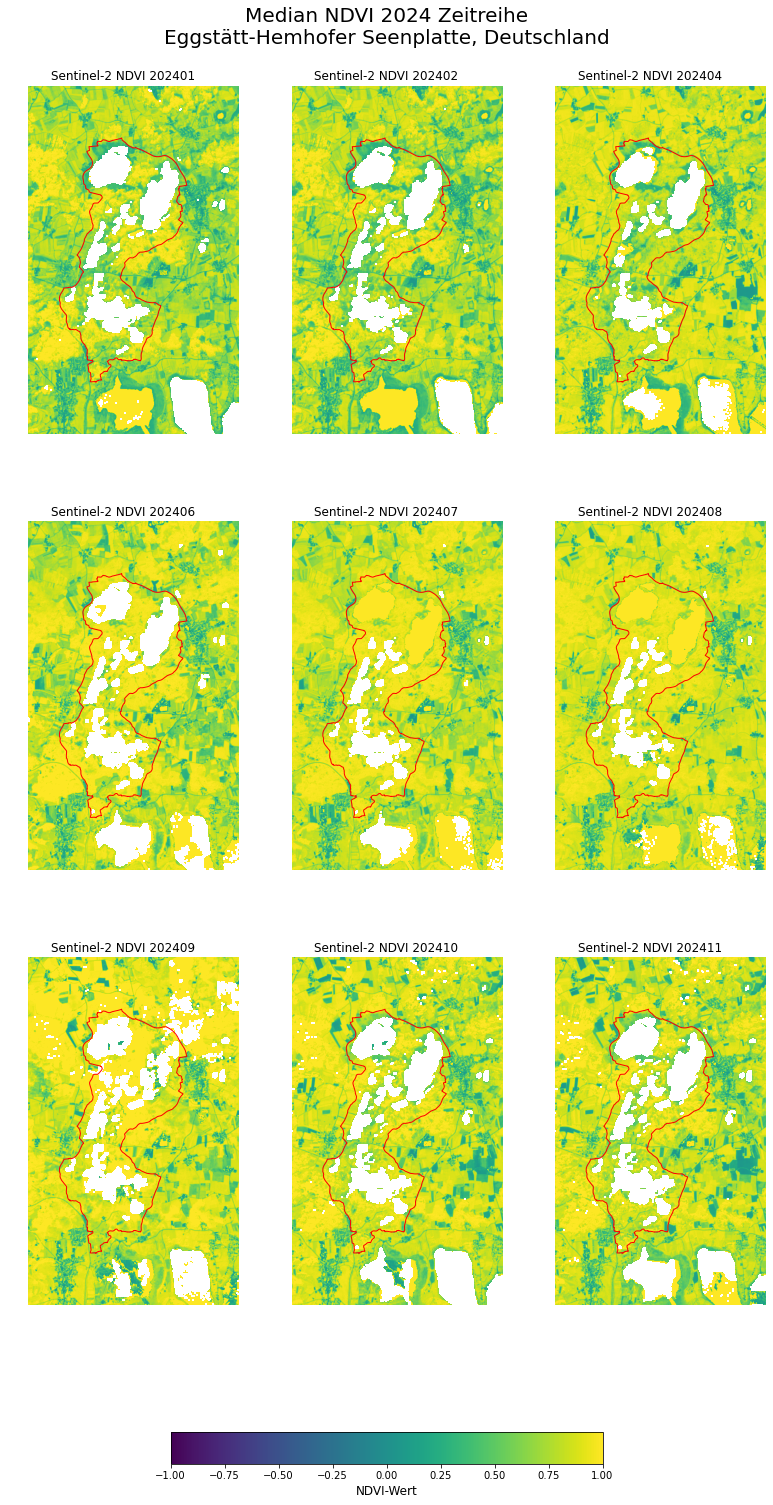

In [234]:
# Liste zur Speicherung der zonale Statistik erstellen
row = []
row.append(["Image", "date", "min", "max", "mean", "median", "std"])

# Erstelle ein 3x3 Subplot-Raster
fig, axs = plt.subplots(3, 3, figsize=(12, 22))  # Größere Gesamtfläche
axs = axs.ravel()

# Durchlaufe die Liste der Sentinel-2 Szenen
i = 0

for scene in flist:  
    
    # Definiere lokale Dateipfade für die Bänder
    green, nir = find_bands(scene)

    # Berechne NDVI
    file_name, epsg_code = produceNDVI(green[0], nir[0], scene, searched_gdf)

    # Transformiere das Koordinatenreferenzsystem der Vektordatei
    searched_gdf = searched_gdf.to_crs(epsg=epsg_code)

    # Speichere und drucke das Datum
    date = file_name[11:17]

    # Zeige NDVI
    showImage(file_name, searched_gdf, date, axs[i])

    # Verwende die zonal_stats()-Funktion für zonale Statistiken
    res = zonal_stats(searched_gdf, file_name,  # Shapefile als Interessensgebiet
                     stats="count min mean max median std", nodata=np.nan)

    # Füge zonale Statistiken als Zeile zur Liste hinzu
    row.append([i, date, res[0]['min'], res[0]['max'], res[0]['mean'], res[0]['median'], res[0]['std']])

    # Erhöhe den Zähler
    i += 1

    # Entferne NDVI-Datei
    os.remove(file_name)
    
# Titel für Subplots erstellen
fig.suptitle(f"Median NDVI {end_year} Zeitreihe\n{name}, Deutschland", fontsize=20, y=0.97)

# Subplot-Abstände anpassen
plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.15,
                    wspace=0.05, hspace=0.25)

# Gemeinsame horizontale Colorbar unterhalb
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # Position etwas weiter zentriert
norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("NDVI-Wert", fontsize=12)

# Anzeigen des Plot
plt.show()
plt.close()

Die Abbildungen sehen gut aus und wir haben das gewünschte 3x3 Subplot-Raster erhalten. Es wird schnell deutlich, dass die Eggstätt-Hemhofer Seenplatte durch Gewässer dominiert wird. Die Gewässer werden zu verschiedenen Jahreszeiten nach der Berechnung des NDVI gefiltert, da sie Werte von kleiner oder größer -1 und 1 besitzen. Im Sommer werden die zwei Seen im Norden des Schutzgebietes (Pelhamer See und Hart-See) nicht gefiltert. Das kann unter anderem an der Algenblüte liegen, die in diesen Monaten besonders stark ist und die Reflektionswerte des Wasser dem der Vegetation umzu ähnelt. Um eine bessere Analyse der NDVI-Werte der saisonalen Veränderungen der Vegetation zu erhalten, wäre es sinnvoll, die Gewässer zu filtern und nicht in die weitere Analyse des NDVI miteinzubeziehen. Hier wird dies der einfachhalt jedoch übersprungen.

#### 12. Anzeigen der monatlichen NDVI Median Werte 

Im letzten Schritt wird aus den einzelnen Reihen des NDVI pro Monat ein DataFrame erstellt. Um die Daten dann zu plotten muss die 'Date' Spalte zunächst in ein anderes Format umgewandelt und anschließend sortiert werden. Ungültige Daten werden außerdem entfernt. Die Spalten 'Date' und 'Median' werden dann verwendet und in Numpy-Arrays umgewandelt und schließlich geplottet.  

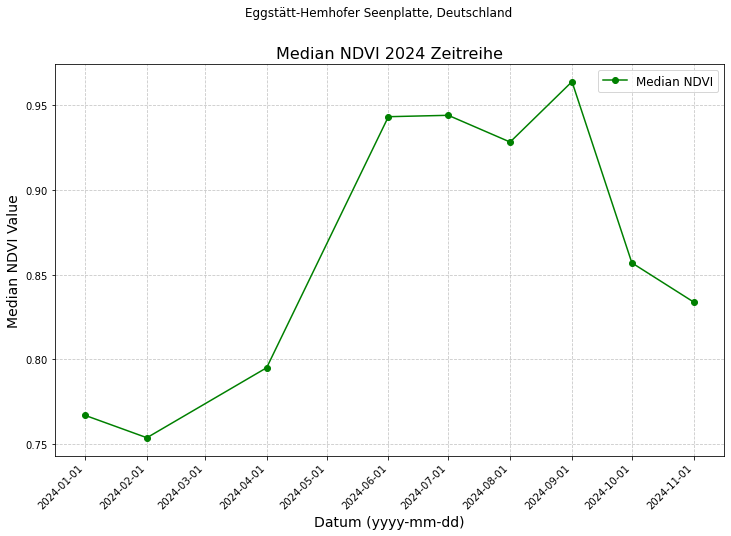

In [231]:
# Erstellen des DataFrame
data = pd.DataFrame(row[1:], columns=row[0])

# Konvertieren der 'date' Spalte von yyyymmdd zu Datumsformat (datetime)
data['date'] = pd.to_datetime(data['date'], format='%Y%m', errors='coerce')

# Sortieren des DataFrame nach 'date' Spalte
data = data.sort_values(by='date')

# Plot median NDVI values
# Konvertiere die 'date'-Spalte in das Datumsformat
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Entferne Zeilen mit ungültigen Daten
dataf = data.dropna(subset=['date'])

# Extrahiere die 'date'- und 'median'-Spalten
dates = data['date']
median_values = data['median']

# Konvertiere in numpy-Arrays
dates = dates.to_numpy()
median_values = median_values.to_numpy()

# Plotte die Zeitreihe
plt.figure(figsize=(12, 8))
plt.plot(dates, median_values, label="Median NDVI", color='green', marker='o')

# Passe die x-Achsen-Ticks und -Labels an
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate(rotation=45)

# Füge Labels, Titel und Legende hinzu
plt.title(f"Median NDVI {end_year} Zeitreihe", fontsize=16)
plt.suptitle(f"{name}, Deutschland")
plt.xlabel("Datum (yyyy-mm-dd)", fontsize=14)
plt.ylabel("Median NDVI Value", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Zeige den Plot an
plt.show()

Wenn wir den finalen Graph der Median NDVI 2024 Zeitreihe betrachten, ähnelt sie sehr stark der Eingangsabbildung, die beispielhaft den Zusammenhang zwischen Saisonalem Pflanzenwachstum und NDVI dargestellt hatte. Auch hier sehen wir hohe NDVI-Werte im Sommer bei maximaler Vegetationsdichte und niedrige Werte in Herbst und Winter, wenn die Produktivität gering ist.